# Importação das bibliotecas

In [1]:
# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Estatísticas
import scipy.stats as stats

# Análise de Séries Temporais
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Seleção Automática de Modelos SARIMA
from pmdarima import auto_arima

# Algoritmo de Aprendizado de Máquina
import xgboost as xgb

## Funções Auxiliares

In [2]:
#@markdown dfdisplay
class dfdisplay(object):
    # Adaptado de https://jakevdp.github.io/PythonDataScienceHandbook/index.html
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <hr>
    <h3 style='font-family:"Courier New", Courier, monospace'>{0}</h3><hr>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        # print(self.args, self.args[0], self.args[1], self.args[2], str(self.args[1]))

    def _repr_html_(self):
        return '\n'.join(self.template.format(str(self.args[0]), eval(a + '.head(' + str(self.args[1]) + ')')._repr_html_())
                         for a in [self.args[2]])

    def __repr__(self):
        return '\n\n'.join(str(self.args[0])+ '\n' + repr(eval(a + '.head(' + str(self.args[1]) + ')'))
                           for a in [self.args[2]])


In [3]:
#@markdown gera_df_stats_latex
from IPython.display import display, Latex, HTML
import warnings

def gera_df_stats_latex(df_stats, titulo):

  warnings.filterwarnings('ignore')
  # latex_table = df_stats.style.to_latex(hrules=True)
  latex_table = df_stats.to_latex(index=None)
  # display(Latex(latex_table))

  latex_table = latex_table.replace('tabular','array')
  latex_table = latex_table.replace('toprule','hline')
  latex_table = latex_table.replace('midrule','hline')
  latex_table = latex_table.replace('bottomrule','hline')

  latex_table = '\\textbf{' + titulo + '} \\\\' + latex_table

  warnings.filterwarnings('default')
  return latex_table

## Métricas de Erro

In [4]:
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    median_absolute_error
)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def error_metrics(y_true, y_pred):

    def error_sub_metrics(medida, y_true, y_pred):
        m = []
        for i in range(len(y_pred)):
            m.append(medida([y_true[i]], [y_pred[i]]))
        m = np.array(m)

        return m.std().round(2), m.min().round(2), m.max().round(2)

    metrics = {}

    # Métricas principais
    metrics['R2'] = np.round(r2_score(y_true, y_pred), 2)
    metrics['RMSE'] = root_mean_squared_error(y_true, y_pred).round(2)
    metrics['MAE'] = mean_absolute_error(y_true, y_pred).round(2)
    metrics['MedAE'] = median_absolute_error(y_true, y_pred).round(2)
    metrics['MAPE'] = mean_absolute_percentage_error(y_true, y_pred).round(2)

    # Estatísticas adicionais para cada métrica
    metrics['RMSE_std'], metrics['RMSE_min'], metrics['RMSE_max'] = error_sub_metrics(root_mean_squared_error, y_true, y_pred)
    metrics['MAE_std'], metrics['MAE_min'], metrics['MAE_max'] = error_sub_metrics(mean_absolute_error, y_true, y_pred)
    metrics['MedAE_std'], metrics['MedAE_min'], metrics['MedAE_max'] = error_sub_metrics(median_absolute_error, y_true, y_pred)
    metrics['MAPE_std'], metrics['MAPE_min'], metrics['MAPE_max'] = error_sub_metrics(mean_absolute_percentage_error, y_true, y_pred)

    return metrics

## Resultados Gráficos

In [5]:
def plot_results2(ax):

  ax.plot(y_true,label='real')
  ax.plot(y_pred, 'r', label='predicted')
  ax.set_title(f'{modelo}\n{AICRMSE_str} = {AICRMSE_value:.2f} , MedAE = {MedAE}',weight='bold',fontsize=10)
  ax.set_xlabel('Período')
  ax.set_ylabel('Receita')
  ax.set_xlabel('Período')
  ax.tick_params(axis='x',labelsize=6)
  ax.tick_params(axis='y',labelsize=8)
  ax.legend(fontsize=8)

  return

## Previsões Janela Deslizante

In [6]:
def forecast_rolling(model, init_data, n_lags, steps):
    predictions = []
    history = list(init_data[-n_lags:])
    # print(history)
    for _ in range(steps):

        X_next = [history[-n_lags:]]
        # print(X_next)

        # Previsão do próximo valor
        next_pred = model.predict(X_next)[0]

        # Adiciona a previsão à lista de previsões
        predictions.append(next_pred)

        # Atualiza o histórico com a previsão atual
        history.append(next_pred)

    return predictions

# Pré-processamento dos dados

In [7]:
df = pd.read_excel("receitas_consolidadas_2021_2024.xlsx")
df.head()

,categoria,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,acessório,5073.5,6584.49,1214.0,2581.99,6648.93,5391.47,7852.47,9498.00,8967.5,...,8690.5,9165.50,7449.99,13999.50,12320.50,21194.5,7934.00,9888.00,14670.0,14239.00
1,beleza_e_estética,1272.5,1405.00,337.5,706.00,1763.50,1700.50,1912.00,1790.50,1854.0,...,1952.0,2443.50,2176.00,3383.50,2255.50,1950.5,1214.00,1450.00,1892.5,1811.00
2,brinquedo,5203.0,4858.00,1563.5,2172.50,6014.50,5068.50,6734.10,5903.50,7812.0,...,5667.4,12910.10,5197.90,12748.60,6292.30,7441.9,5041.00,7349.20,6774.1,7377.20
3,calçado,1684.0,1426.00,416.0,753.00,2943.00,3008.00,2580.00,2085.00,1415.0,...,1931.0,1857.00,1559.00,1678.00,1757.00,2133.0,1463.00,2287.00,2701.0,2101.00
4,doce,487.0,566.50,35.0,133.25,477.00,360.00,601.25,734.25,596.0,...,1422.0,1640.25,1476.00,1866.25,1545.75,2227.0,1095.25,1532.25,1666.5,1844.75


In [8]:
df['categoria'].unique()

array(['acessório', 'beleza_e_estética', 'brinquedo', 'calçado', 'doce',
       'eletrônico', 'enfeite', 'escritório', 'material_escolar', 'natal',
       'pet', 'presente', 'utilidade', 'vestuário', 'Total'], dtype=object)

In [9]:
import unicodedata

def normalize_categoria(text):
  text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
  text = text.replace('_', '-')
  text = text.lower()
  return text

df['categoria'] = df['categoria'].apply(normalize_categoria)
df['categoria'].unique()

array(['acessorio', 'beleza-e-estetica', 'brinquedo', 'calcado', 'doce',
       'eletronico', 'enfeite', 'escritorio', 'material-escolar', 'natal',
       'pet', 'presente', 'utilidade', 'vestuario', 'total'], dtype=object)

In [10]:
df.to_csv('receitas_consolidadas_2021_2024.csv', index=False)

In [11]:
df = pd.read_csv("receitas_consolidadas_2021_2024.csv",index_col='categoria')
df.head()

,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
categoria,,,,,,,,,,,,,,,,,,,,,
acessorio,5073.5,6584.49,1214.0,2581.99,6648.93,5391.47,7852.47,9498.00,8967.5,9101.49,...,8690.5,9165.50,7449.99,13999.50,12320.50,21194.5,7934.00,9888.00,14670.0,14239.00
beleza-e-estetica,1272.5,1405.00,337.5,706.00,1763.50,1700.50,1912.00,1790.50,1854.0,2465.50,...,1952.0,2443.50,2176.00,3383.50,2255.50,1950.5,1214.00,1450.00,1892.5,1811.00
brinquedo,5203.0,4858.00,1563.5,2172.50,6014.50,5068.50,6734.10,5903.50,7812.0,16620.00,...,5667.4,12910.10,5197.90,12748.60,6292.30,7441.9,5041.00,7349.20,6774.1,7377.20
calcado,1684.0,1426.00,416.0,753.00,2943.00,3008.00,2580.00,2085.00,1415.0,1426.00,...,1931.0,1857.00,1559.00,1678.00,1757.00,2133.0,1463.00,2287.00,2701.0,2101.00
doce,487.0,566.50,35.0,133.25,477.00,360.00,601.25,734.25,596.0,659.75,...,1422.0,1640.25,1476.00,1866.25,1545.75,2227.0,1095.25,1532.25,1666.5,1844.75


In [12]:
ts = pd.DataFrame()

for categoria in df.index:
  ts = pd.concat([ts,df.loc[categoria, :]],axis=1)

ts.index = pd.date_range(start='1/1/2021', periods=len(ts), freq='MS')
ts.head()

,acessorio,beleza-e-estetica,brinquedo,calcado,doce,eletronico,enfeite,escritorio,material-escolar,natal,pet,presente,utilidade,vestuario,total
2021-01-01,5073.50,1272.5,5203.0,1684.0,487.00,4007.75,3100.25,1167.20,1771.9,150.0,407.0,1018.5,3463.60,323.0,29129.20
2021-02-01,6584.49,1405.0,4858.0,1426.0,566.50,3429.00,3154.50,2313.65,9805.6,142.8,105.0,1266.3,5229.40,656.5,40942.74
2021-03-01,1214.00,337.5,1563.5,416.0,35.00,727.50,715.00,560.35,1424.9,0.0,0.0,206.1,1288.40,242.5,8730.75
2021-04-01,2581.99,706.0,2172.5,753.0,133.25,1319.50,1488.00,561.20,2165.8,95.0,25.0,373.2,2216.25,1776.0,16366.69
2021-05-01,6648.93,1763.5,6014.5,2943.0,477.00,4120.50,6052.50,1726.85,4696.5,272.6,250.0,2309.4,5901.30,7644.5,50821.08


# Dados - Estacionariedade - Autocorrelações

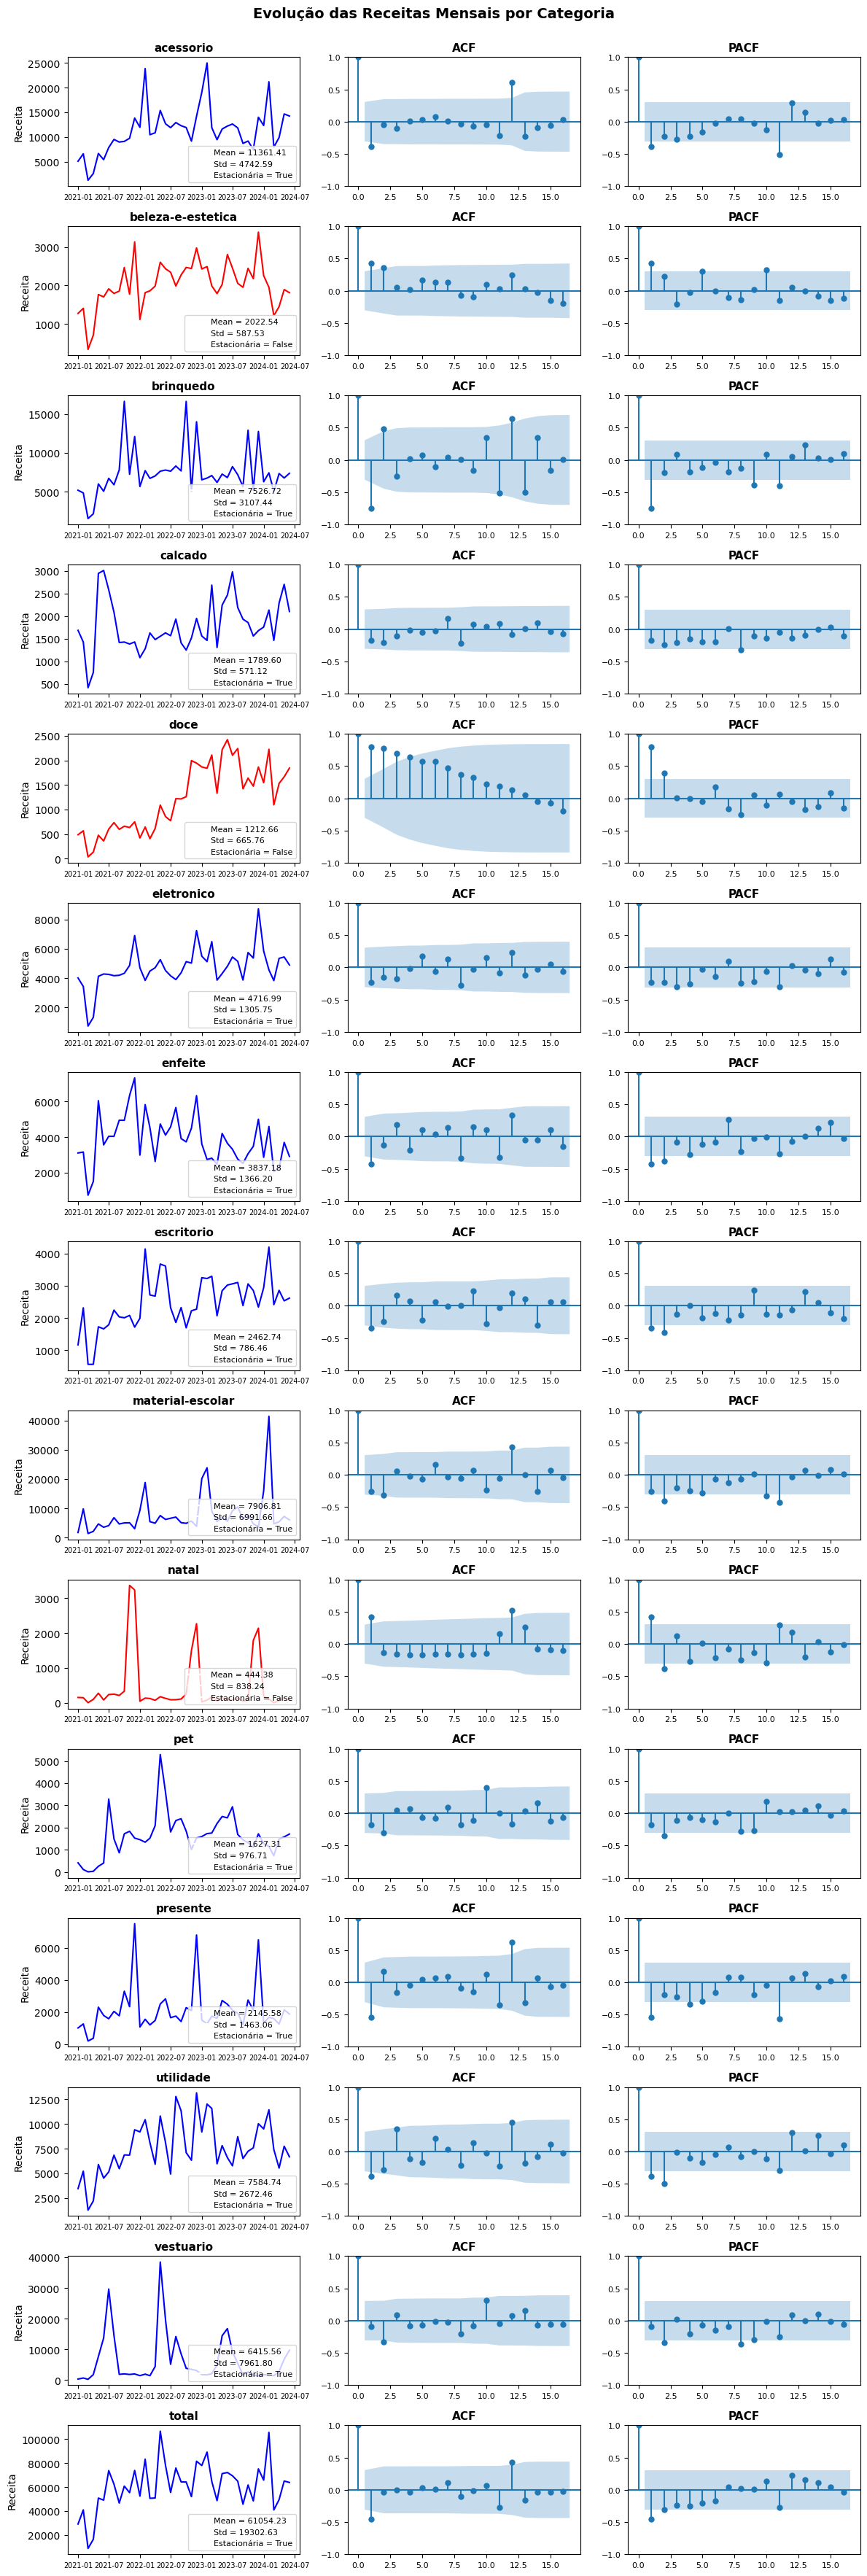

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

fig, ax = plt.subplots(len(ts.columns), 3, figsize=(12, 36))
fig.suptitle('Evolução das Receitas Mensais por Categoria', weight='bold',fontsize=14)

adfuller_dict = {}

for i, categoria in enumerate(ts.columns):

  result = adfuller(ts[categoria])

  if result[1] <= 0.05:
      estacionaria = True
  else:
      estacionaria = False

  adfuller_dict[categoria] = {'estacionaria': estacionaria, 'p-value': result[1]}

  ax[i,0].plot(ts[categoria],color={True:'blue',False:'red'}[estacionaria])
  ax[i,0].set_title(categoria,weight='bold',fontsize=11)
  ax[i,0].set_ylabel('Receita')
  ax[i,0].plot([], label=f'Mean = {ts[categoria].values.mean():.2f}',color='white')
  ax[i,0].plot([], label=f'Std = {ts[categoria].values.std():.2f}',color='white')
  ax[i,0].plot([], label=f'Estacionária = {estacionaria}',color='white')
  ax[i,0].legend(loc='lower right',fontsize=8)
  ax[i,0].tick_params(axis='x',labelsize=7)

  if not estacionaria:
    plot_acf(ts[categoria].values, lags=16, ax=ax[i,1])
  else:
    plot_acf(ts[categoria].diff().dropna().values, lags=16, ax=ax[i,1])
  ax[i,1].set_title('ACF',weight='bold',fontsize=11)
  ax[i,1].tick_params(axis='x',labelsize=8)
  ax[i,1].tick_params(axis='y',labelsize=8)

  if not estacionaria:
    plot_pacf(ts[categoria].values, lags=16, ax=ax[i,2])
  else:
    plot_pacf(ts[categoria].diff().dropna().values, lags=16, ax=ax[i,2])
  ax[i,2].set_title('PACF',weight='bold',fontsize=11)
  ax[i,2].tick_params(axis='x',labelsize=8)
  ax[i,2].tick_params(axis='y',labelsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [14]:
adfuller_df = pd.DataFrame.from_dict(adfuller_dict, orient='index').reset_index().sort_values('p-value')
adfuller_df.columns = ['categoria', 'estacionaria', 'p-value']
adfuller_df['p-value'] = adfuller_df['p-value'].apply(lambda x: f'{x:.2f}')
adfuller_df

,categoria,estacionaria,p-value
11,presente,True,0.00
14,total,True,0.00
6,enfeite,True,0.00
8,material-escolar,True,0.00
12,utilidade,True,0.00
0,acessorio,True,0.00
2,brinquedo,True,0.00
7,escritorio,True,0.00
3,calcado,True,0.00
13,vestuario,True,0.00


In [15]:
latex_table = gera_df_stats_latex(adfuller_df,'Estacionariedade')
display(Latex(latex_table))

<IPython.core.display.Latex object>

# SARIMA: `statsmodels`

In [16]:
p_max = 2; d_max = 1; q_max = 3
orders = [(p, d, q) for p in range(p_max+1) for d in range(d_max+1) for q in range(q_max+1)]

P_max = 1; D_ = 0; Q_ = 0; S_ = 12
seasonal_orders = [(P, D, Q, S) for P in range(P_max+1) for D in [D_] for Q in [Q_] for S in [S_]]

orders, seasonal_orders

([(0, 0, 0),
  (0, 0, 1),
  (0, 0, 2),
  (0, 0, 3),
  (0, 1, 0),
  (0, 1, 1),
  (0, 1, 2),
  (0, 1, 3),
  (1, 0, 0),
  (1, 0, 1),
  (1, 0, 2),
  (1, 0, 3),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 1, 3),
  (2, 0, 0),
  (2, 0, 1),
  (2, 0, 2),
  (2, 0, 3),
  (2, 1, 0),
  (2, 1, 1),
  (2, 1, 2),
  (2, 1, 3)],
 [(0, 0, 0, 12), (1, 0, 0, 12)])

In [17]:
best_categoria_models = {}
for categoria in ts.columns:
  print(f'Processando {categoria}...')
  df = ts[categoria]
#-------------------------------------------------------------------------------

  models_stats = {}
  models_fittedvalues = {}

  for order in orders:
    for seasonal_order in seasonal_orders:
      model = ARIMA(df, order=order, seasonal_order=seasonal_order)
      try:
        results = model.fit(method_kwargs={'maxiter':1000})
      except:
        continue

      models_stats[(model.order, model.seasonal_order)] = {'AIC':results.aic, 'mse':results.mse, 'mae':results.mae}
      models_fittedvalues[(model.order, model.seasonal_order)] = {'fittedvalues':results.fittedvalues}

  best_aic_model = min(models_stats, key=lambda x: models_stats[x]['AIC'])

  print(f"The model with the lowest AIC is: {best_aic_model} with AIC = {models_stats[best_aic_model]['AIC'].round(2)} and mae = {models_stats[best_aic_model]['mae'].round(2)}")

#-------------------------------------------------------------------------------
  best_categoria_models[categoria] = {'best_aic_model':best_aic_model, 'models_stats':models_stats[best_aic_model], 'models_fittedvalues':models_fittedvalues[best_aic_model]}

Processando acessorio...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The model with the lowest AIC is: ((0, 1, 1), (1, 0, 0, 12)) with AIC = 787.21 and mae = 2673.08
Processando beleza-e-estetica...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users

The model with the lowest AIC is: ((0, 1, 1), (1, 0, 0, 12)) with AIC = 632.41 and mae = 424.36
Processando brinquedo...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users

The model with the lowest AIC is: ((0, 1, 2), (1, 0, 0, 12)) with AIC = 759.41 and mae = 1856.35
Processando calcado...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible start

The model with the lowest AIC is: ((1, 1, 1), (0, 0, 0, 12)) with AIC = 637.99 and mae = 399.58
Processando doce...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible start

The model with the lowest AIC is: ((0, 1, 1), (0, 0, 0, 12)) with AIC = 600.01 and mae = 266.33
Processando eletronico...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters

The model with the lowest AIC is: ((2, 1, 2), (1, 0, 0, 12)) with AIC = 701.32 and mae = 884.03
Processando enfeite...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible start

The model with the lowest AIC is: ((0, 1, 1), (1, 0, 0, 12)) with AIC = 712.9 and mae = 1082.42
Processando escritorio...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible start

The model with the lowest AIC is: ((0, 1, 1), (1, 0, 0, 12)) with AIC = 656.75 and mae = 538.92
Processando material-escolar...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal 

The model with the lowest AIC is: ((2, 0, 2), (1, 0, 0, 12)) with AIC = 14.0 and mae = 3750.69
Processando natal...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible start

The model with the lowest AIC is: ((0, 1, 2), (1, 0, 0, 12)) with AIC = 633.33 and mae = 259.16
Processando pet...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible start

The model with the lowest AIC is: ((0, 1, 2), (0, 0, 0, 12)) with AIC = 674.04 and mae = 486.32
Processando presente...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible start

The model with the lowest AIC is: ((0, 0, 2), (1, 0, 0, 12)) with AIC = 672.59 and mae = 561.32
Processando utilidade...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible start

The model with the lowest AIC is: ((2, 1, 0), (1, 0, 0, 12)) with AIC = 745.95 and mae = 1638.55
Processando vestuario...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible start

The model with the lowest AIC is: ((0, 1, 2), (1, 0, 0, 12)) with AIC = 847.73 and mae = 3669.47
Processando total...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users

The model with the lowest AIC is: ((0, 1, 1), (1, 0, 0, 12)) with AIC = 923.2 and mae = 13908.65


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [18]:
df_models_stats = pd.DataFrame.from_dict(best_categoria_models, orient='index')
df_models_stats = df_models_stats.rename(columns={'models_stats': 'models_stats_dict'})

# normalizar o atributo 'models_stats'
df_models_stats = pd.concat([df_models_stats, df_models_stats['models_stats_dict'].apply(pd.Series)], axis=1)
df_models_stats = df_models_stats.drop('models_stats_dict', axis=1)


df_models_stats.reset_index(inplace=True)
df_models_stats.rename(columns={'index': 'categoria'}, inplace=True)

df_models_stats[['categoria', 'best_aic_model', 'AIC']].sort_values('AIC')

,categoria,best_aic_model,AIC
8,material-escolar,"((2, 0, 2), (1, 0, 0, 12))",14.000000
4,doce,"((0, 1, 1), (0, 0, 0, 12))",600.012929
1,beleza-e-estetica,"((0, 1, 1), (1, 0, 0, 12))",632.405302
9,natal,"((0, 1, 2), (1, 0, 0, 12))",633.328987
3,calcado,"((1, 1, 1), (0, 0, 0, 12))",637.985288
7,escritorio,"((0, 1, 1), (1, 0, 0, 12))",656.753346
11,presente,"((0, 0, 2), (1, 0, 0, 12))",672.591375
10,pet,"((0, 1, 2), (0, 0, 0, 12))",674.043816
5,eletronico,"((2, 1, 2), (1, 0, 0, 12))",701.318396
6,enfeite,"((0, 1, 1), (1, 0, 0, 12))",712.895693


In [19]:
temp = df_models_stats[['categoria', 'best_aic_model', 'AIC']].sort_values('AIC')
temp.columns = [x.replace('_','-') for x in temp.columns]
latex_table = gera_df_stats_latex(temp,'SARIMA, por categoria')

display(Latex(latex_table))

<IPython.core.display.Latex object>

Processando acessorio...
Processando beleza-e-estetica...
Processando brinquedo...
Processando calcado...
Processando doce...
Processando eletronico...
Processando enfeite...
Processando escritorio...
Processando material-escolar...
Processando natal...
Processando pet...
Processando presente...
Processando utilidade...
Processando vestuario...
Processando total...


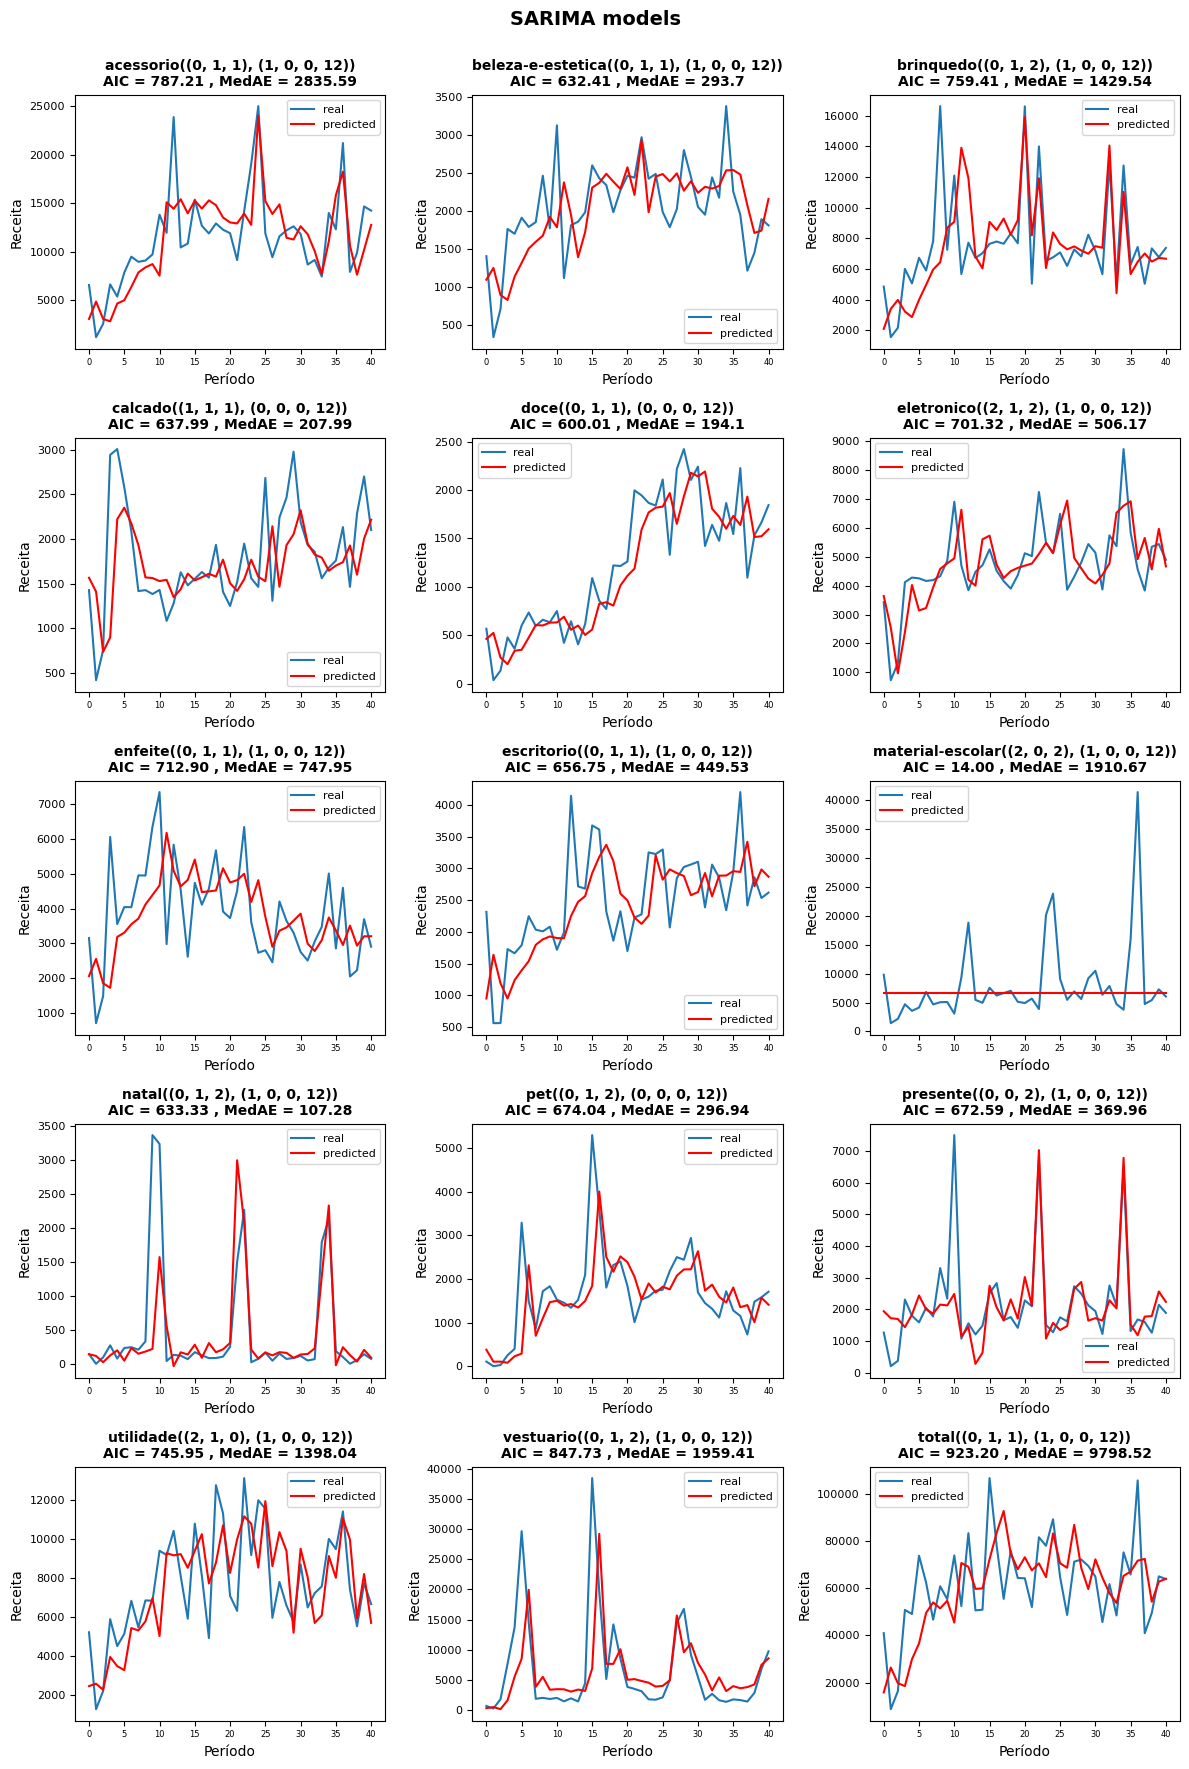

In [20]:
model_error = pd.DataFrame()

fig, ax = plt.subplots(5, 3, figsize=(12, 18))
ax = ax.flatten()
fig.suptitle('SARIMA models', weight='bold',fontsize=14)

for i, categoria in zip(range(len(ts.columns)), ts.columns):

  print(f'Processando {categoria}...')
  df = ts[[categoria]]
  y_pred = pd.DataFrame.from_dict(best_categoria_models[categoria]['models_fittedvalues'])
  best_aic_model = best_categoria_models[categoria]['best_aic_model']
#-------------------------------------------------------------------------------

  #
  # get error metrics
  #
  metrics = {}

  metrics_df = pd.DataFrame.from_dict(error_metrics(df.iloc[1::,0].values, y_pred['fittedvalues'][1::].values), orient='index').transpose()
  metrics_df['order'] = str(best_aic_model[0])
  metrics_df['seasonal order'] = str(best_aic_model[1])
  metrics_df['AIC'] = best_categoria_models[categoria]['models_stats']['AIC'].round(2)
  metrics_df = metrics_df.set_index(['order','seasonal order'])

  select_metrics = ['AIC', 'RMSE', 'RMSE_std', 'MAPE',  'MAPE_std', 'MAPE_max', 'MAPE_min', 'MedAE' ]
  model_error = pd.concat([model_error,metrics_df[select_metrics]])

  #
  # plot results
  #

  y_true = df.iloc[1::,0].values
  y_pred = y_pred['fittedvalues'][1::].values
  AICRMSE_str = 'AIC'
  AICRMSE_value = metrics_df['AIC'].values[0].round(2)
  MedAE = metrics_df['MedAE'].values[0].round(2)
  modelo = categoria + str(best_aic_model)
  errors = y_true - y_pred

  plot_results2(ax[i])

#-------------------------------------------------------------------------------
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

model_error.reset_index(inplace=True)
model_error['categoria'] = ts.columns

In [21]:
model_error.sort_values('MAPE')

,order,seasonal order,AIC,RMSE,RMSE_std,MAPE,MAPE_std,MAPE_max,MAPE_min,MedAE,categoria
5,"(2, 1, 2)","(1, 0, 0, 12)",701.32,1078.74,714.89,2.200000e-01,3.900000e-01,2.500000e+00,0.00,506.17,eletronico
3,"(1, 1, 1)","(0, 0, 0, 12)",637.99,546.26,403.48,2.300000e-01,3.800000e-01,2.390000e+00,0.01,207.99,calcado
12,"(2, 1, 0)","(1, 0, 0, 12)",745.95,1934.92,1096.79,2.400000e-01,2.000000e-01,1.010000e+00,0.01,1398.04,utilidade
1,"(0, 1, 1)","(1, 0, 0, 12)",632.41,516.24,321.79,2.700000e-01,4.400000e-01,2.700000e+00,0.01,293.70,beleza-e-estetica
7,"(0, 1, 1)","(1, 0, 0, 12)",656.75,682.30,437.47,2.700000e-01,3.400000e-01,1.920000e+00,0.00,449.53,escritorio
14,"(0, 1, 1)","(1, 0, 0, 12)",923.20,17363.28,10872.99,2.700000e-01,3.400000e-01,2.020000e+00,0.00,9798.52,total
2,"(0, 1, 2)","(1, 0, 0, 12)",759.41,2624.93,1934.07,2.800000e-01,3.100000e-01,1.450000e+00,0.01,1429.54,brinquedo
0,"(0, 1, 1)","(1, 0, 0, 12)",787.21,3234.44,1904.16,3.000000e-01,4.600000e-01,3.020000e+00,0.01,2835.59,acessorio
6,"(0, 1, 1)","(1, 0, 0, 12)",712.90,1355.05,876.73,3.300000e-01,4.200000e-01,2.580000e+00,0.02,747.95,enfeite
8,"(2, 0, 2)","(1, 0, 0, 12)",14.00,7149.05,6103.03,4.800000e-01,6.300000e-01,3.670000e+00,0.00,1910.67,material-escolar


In [22]:
temp = model_error.sort_values('MAPE')
temp.columns = [x.replace('_','-') for x in temp.columns]
latex_table = gera_df_stats_latex(temp,'SARIMA, por categoria')

display(Latex(latex_table))

<IPython.core.display.Latex object>

# Sarima: Predições 1M

In [23]:
pred_1M_categoria = {}

for i, categoria in zip(range(len(ts.columns)), ts.columns):

  print(f'Processando {categoria}...')
  df = ts[[categoria]]
  best_aic_model = best_categoria_models[categoria]['best_aic_model']

#-------------------------------------------------------------------------------

  order = best_aic_model[0]
  seasonal_order = best_aic_model[1]

  resultados = {}

  for i in range(30, 42):
      train = df.iloc[i-30:i]

      try:
          sarima_model = ARIMA(train, order=order, seasonal_order=seasonal_order)
          sarima_fitted = sarima_model.fit()

          resultados[sarima_fitted.forecast(steps=1).index.values[0]] = sarima_fitted.forecast(steps=1).iloc[0]

      except Exception as e:
          print(f"Erro ao ajustar ou prever para o índice {i}: {e}")
          resultados[i] = {'aic': None, 'pred': None}

  pred = pd.DataFrame.from_dict(resultados, orient='index')
  pred.columns = ['pred']
  # pred

#-------------------------------------------------------------------------------

  pred_1M_categoria[categoria] = pred


Processando acessorio...
Processando beleza-e-estetica...
Processando brinquedo...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal 

Processando calcado...
Processando doce...
Processando eletronico...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting a

Processando enfeite...
Processando escritorio...
Processando material-escolar...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jhona

Processando natal...
Processando pet...
Processando presente...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processando utilidade...
Processando vestuario...
Processando total...


Processando acessorio...
Processando beleza-e-estetica...
Processando brinquedo...
Processando calcado...
Processando doce...
Processando eletronico...
Processando enfeite...
Processando escritorio...
Processando material-escolar...
Processando natal...
Processando pet...
Processando presente...
Processando utilidade...
Processando vestuario...
Processando total...


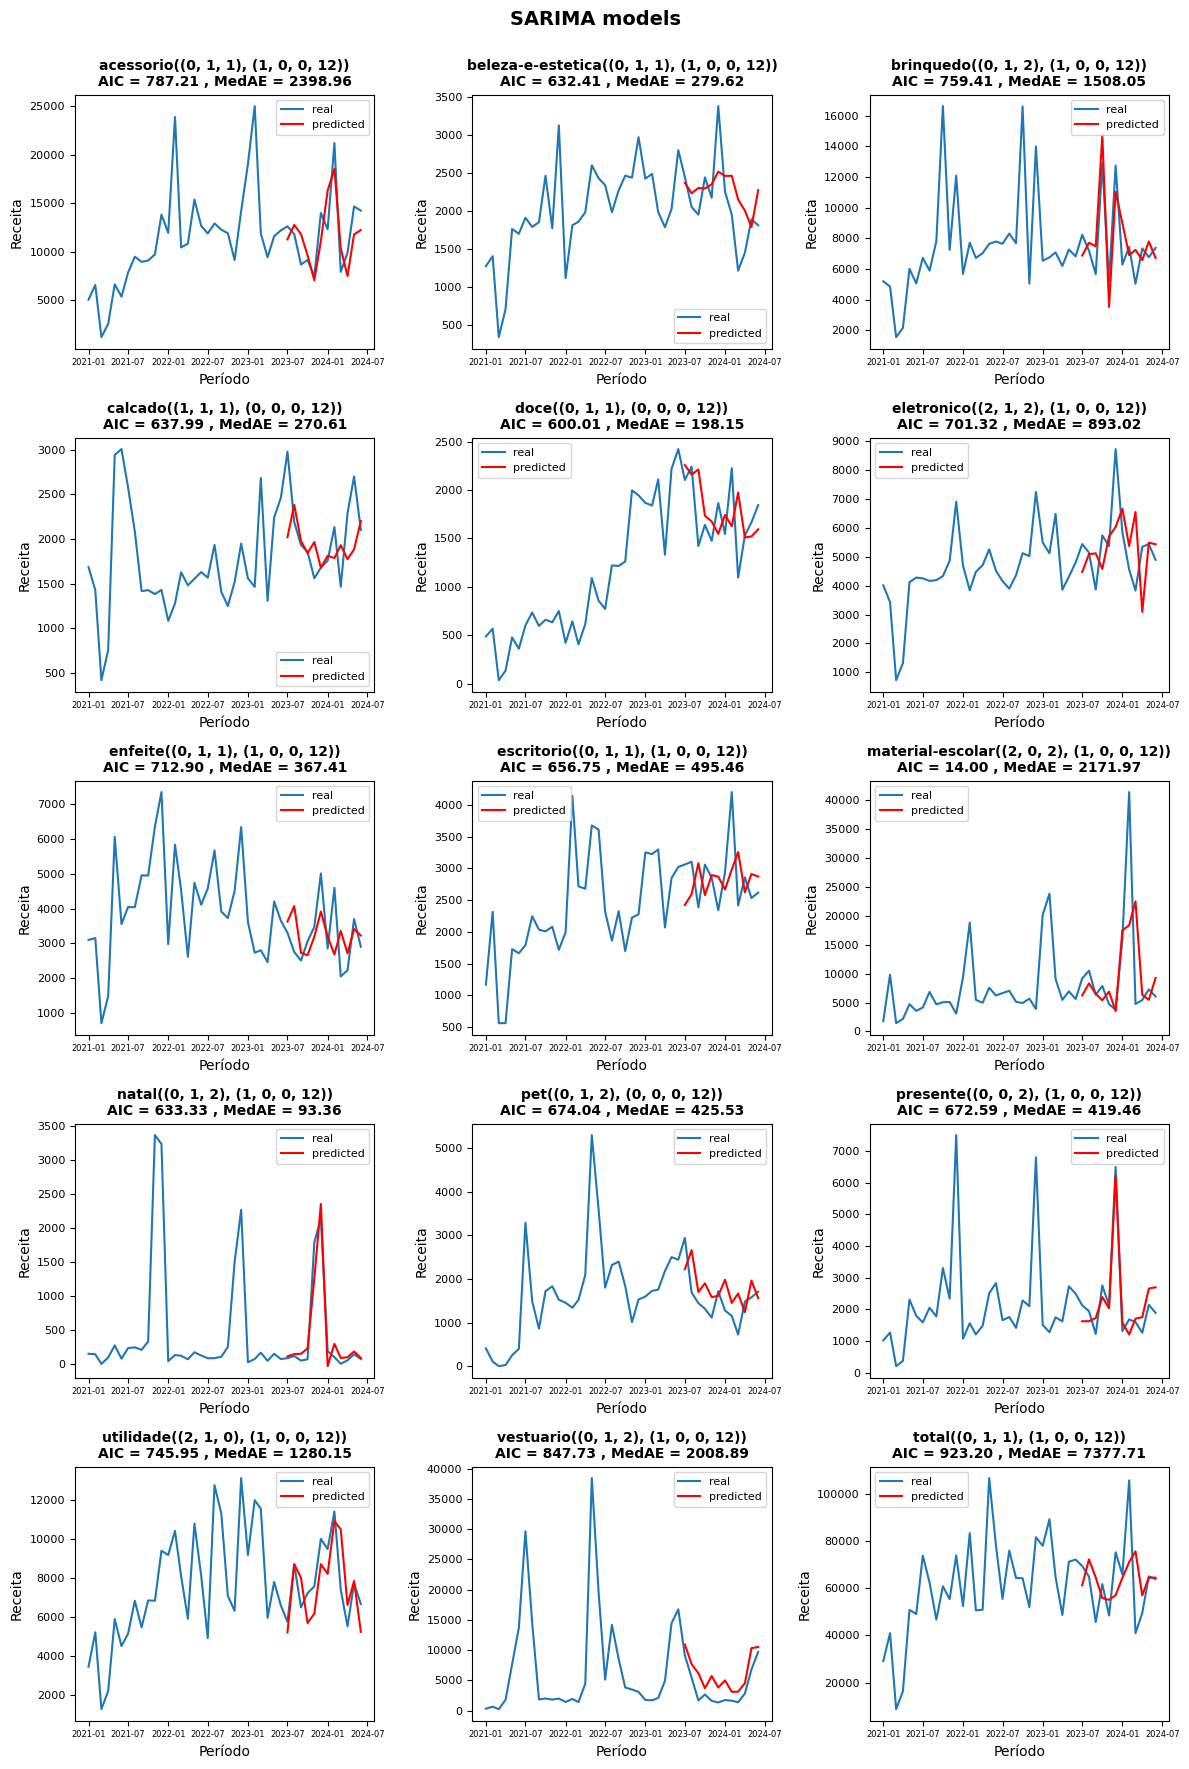

In [24]:
model_error_arima_1M = pd.DataFrame()

fig, ax = plt.subplots(5, 3, figsize=(12, 18))
ax = ax.flatten()
fig.suptitle('SARIMA models', weight='bold',fontsize=14)

for i, categoria in zip(range(len(ts.columns)), ts.columns):

  print(f'Processando {categoria}...')
  df = ts[[categoria]]
  y_pred = pd.DataFrame.from_dict(best_categoria_models[categoria]['models_fittedvalues'])
  best_aic_model = best_categoria_models[categoria]['best_aic_model']
  pred = pred_1M_categoria[categoria]
#-------------------------------------------------------------------------------

  #
  # get error metrics
  #
  metrics = {}

  metrics_df = pd.DataFrame.from_dict(error_metrics(df.iloc[-12::,0].values, pred.pred.values), orient='index').transpose()
  metrics_df['order'] = str(best_aic_model[0])
  metrics_df['seasonal order'] = str(best_aic_model[1])
  metrics_df['AIC'] = best_categoria_models[categoria]['models_stats']['AIC'].round(2)
  metrics_df = metrics_df.set_index(['order','seasonal order'])

  select_metrics = ['AIC', 'RMSE', 'RMSE_std', 'MAPE',  'MAPE_std', 'MAPE_max', 'MAPE_min', 'MedAE' ]
  model_error_arima_1M = pd.concat([model_error_arima_1M,metrics_df[select_metrics]])

  #
  # plot results
  #

  y_true = df.iloc[:,0]   # série completa
  y_pred = pred           # predição, final da série
  AICRMSE_str = 'AIC'
  AICRMSE_value = metrics_df['AIC'].values[0].round(2)
  MedAE = metrics_df['MedAE'].values[0].round(2)
  modelo = categoria + str(best_aic_model)
  y_true = df.iloc[:,0]   # série completa
  y_pred = pred           # predição, final da série

  plot_results2(ax[i])

#-------------------------------------------------------------------------------
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

model_error_arima_1M.reset_index(inplace=True)
model_error_arima_1M['categoria'] = ts.columns

In [25]:
model_error_arima_1M.sort_values('MAPE')

,order,seasonal order,AIC,RMSE,RMSE_std,MAPE,MAPE_std,MAPE_max,MAPE_min,MedAE,categoria
3,"(1, 1, 1)","(0, 0, 0, 12)",637.99,448.15,306.49,0.15,0.12,0.32,0.00,270.61,calcado
12,"(2, 1, 0)","(1, 0, 0, 12)",745.95,1391.19,784.65,0.16,0.11,0.42,0.00,1280.15,utilidade
0,"(0, 1, 1)","(1, 0, 0, 12)",787.21,2378.67,1075.09,0.18,0.10,0.36,0.05,2398.96,acessorio
7,"(0, 1, 1)","(1, 0, 0, 12)",656.75,591.31,302.45,0.18,0.10,0.35,0.01,495.46,escritorio
2,"(0, 1, 2)","(1, 0, 0, 12)",759.41,1555.58,678.02,0.20,0.13,0.44,0.07,1508.05,brinquedo
1,"(0, 1, 1)","(1, 0, 0, 12)",632.41,472.97,279.33,0.21,0.20,0.77,0.03,279.62,beleza-e-estetica
4,"(0, 1, 1)","(0, 0, 0, 12)",600.01,415.00,274.28,0.21,0.23,0.80,0.01,198.15,doce
14,"(0, 1, 1)","(1, 0, 0, 12)",923.20,16699.76,11591.55,0.21,0.23,0.85,0.01,7377.71,total
5,"(2, 1, 2)","(1, 0, 0, 12)",701.32,1453.40,902.97,0.22,0.19,0.71,0.01,893.02,eletronico
6,"(0, 1, 1)","(1, 0, 0, 12)",712.90,875.52,539.97,0.22,0.18,0.64,0.08,367.41,enfeite


In [26]:
temp = model_error_arima_1M.sort_values('MAPE')
temp.columns = [x.replace('_','-') for x in temp.columns]
latex_table = gera_df_stats_latex(temp,'SARIMA, por categoria')

display(Latex(latex_table))

<IPython.core.display.Latex object>

### Meses com maior e menor erro de predição

Processando acessorio...
Processando beleza-e-estetica...
Processando brinquedo...
Processando calcado...
Processando doce...
Processando eletronico...
Processando enfeite...
Processando escritorio...
Processando material-escolar...
Processando natal...
Processando pet...
Processando presente...
Processando utilidade...
Processando vestuario...
Processando total...


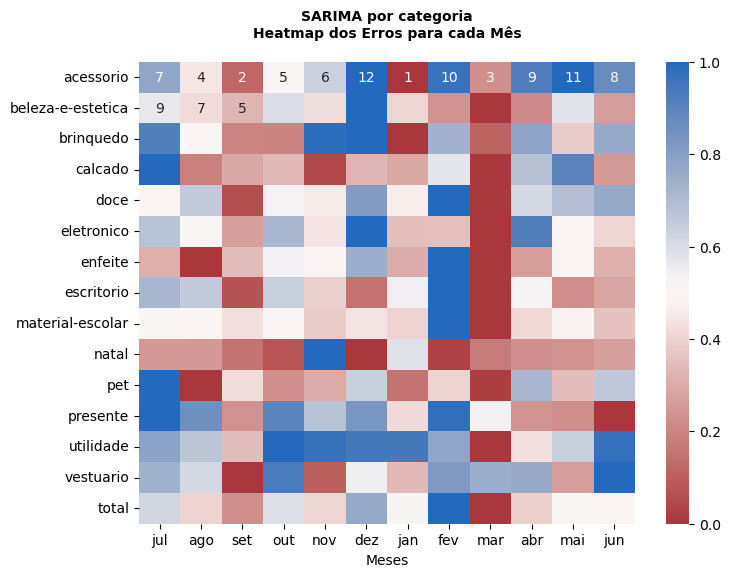

In [27]:
df_heatmap_all = pd.DataFrame()

for i, categoria in zip(range(len(ts.columns)), ts.columns):

  print(f'Processando {categoria}...')
  df = ts[[categoria]]
  pred = pred_1M_categoria[categoria]

  errors = df.iloc[-12::,0].values - pred.pred.values

#-------------------------------------------------------------------------------
  labels = ['jul','ago','set','out','nov','dez','jan','fev','mar','abr','mai','jun']

  df_heatmap = pd.DataFrame({'labels': labels, 'errors': errors})

  df_heatmap = df_heatmap.pivot_table(index='labels', values='errors').transpose()
  df_heatmap = df_heatmap[['jul','ago','set','out','nov','dez','jan','fev','mar','abr','mai','jun']] # reorder

  df_heatmap_all = pd.concat([df_heatmap_all,df_heatmap])

#-------------------------------------------------------------------------------

df_heatmap_all.index = ts.columns
df_heatmap_all = df_heatmap_all.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1) # normaliza por categoria

plt.figure(figsize=(8,6))
sns.heatmap(df_heatmap_all, annot=df_heatmap_all.rank(axis="columns"), fmt=".0f", cmap=sns.color_palette("vlag_r", as_cmap=True))
plt.title(f'SARIMA por categoria\nHeatmap dos Erros para cada Mês\n',weight='bold',fontsize=10)
plt.xlabel('Meses')

plt.show()

# Sarima: Predições 3M

In [28]:
pred_3M_categoria = {}

for i, categoria in zip(range(len(ts.columns)), ts.columns):

  print(f'Processando {categoria}...')
  df = ts[[categoria]]
  best_aic_model = best_categoria_models[categoria]['best_aic_model']

#-------------------------------------------------------------------------------

  order = best_aic_model[0]
  seasonal_order = best_aic_model[1]

  resultados = {}

  for i in range(30, 40):
      train = df.iloc[i-30:i]

      try:
          sarima_model = ARIMA(train, order=order, seasonal_order=seasonal_order)
          sarima_fitted = sarima_model.fit()

          resultados[sarima_fitted.forecast(steps=1).index.values[0]] = sarima_fitted.forecast(steps=3).iloc[0:3].values

      except Exception as e:
          print(f"Erro ao ajustar ou prever para o índice {i}: {e}")
          resultados[i] = {'aic': None, 'pred': None}

  pred = pd.DataFrame.from_dict(resultados, orient='index')
  # pred.columns = ['pred']

#-------------------------------------------------------------------------------

  pred_3M_categoria[categoria] = pred

Processando acessorio...
Processando beleza-e-estetica...
Processando brinquedo...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal 

Processando calcado...
Processando doce...
Processando eletronico...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting a

Processando enfeite...
Processando escritorio...
Processando material-escolar...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jhona

Processando natal...
Processando pet...
Processando presente...


C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processando utilidade...
Processando vestuario...
Processando total...


In [29]:
valores_window_3M_categoria = {}

for i, categoria in zip(range(len(ts.columns)), ts.columns):

  print(f'Processando {categoria}...')
  df = ts[[categoria]]
  best_aic_model = best_categoria_models[categoria]['best_aic_model']

#-------------------------------------------------------------------------------
  valores_window = []
  for i in range(30, 40):
      valores_window.append(df.iloc[i:i+3].values)
#-------------------------------------------------------------------------------

  valores_window_3M_categoria[categoria] = valores_window

Processando acessorio...
Processando beleza-e-estetica...
Processando brinquedo...
Processando calcado...
Processando doce...
Processando eletronico...
Processando enfeite...
Processando escritorio...
Processando material-escolar...
Processando natal...
Processando pet...
Processando presente...
Processando utilidade...
Processando vestuario...
Processando total...


In [30]:
model_error_arima_3M = pd.DataFrame()

for i, categoria in zip(range(len(ts.columns)), ts.columns):

  print(f'Processando {categoria}...')
  df = ts[[categoria]]
  best_aic_model = best_categoria_models[categoria]['best_aic_model']
  pred = pred_3M_categoria[categoria]

#-------------------------------------------------------------------------------

  metrics_df = pd.DataFrame.from_dict(error_metrics(np.array(valores_window).flatten(), np.array(pred.values).flatten()), orient='index').transpose()
  metrics_df['order'] = str(best_aic_model[0])
  metrics_df['seasonal order'] = str(best_aic_model[1])
  metrics_df['AIC'] = models_stats[best_aic_model]['AIC'].round(2)
  metrics_df = metrics_df.set_index(['order','seasonal order'])

  select_metrics = ['AIC', 'RMSE', 'RMSE_std', 'MAPE',  'MAPE_std', 'MAPE_max', 'MAPE_min', 'MedAE' ]
  model_error = metrics_df[select_metrics]

  model_error_arima_3M = pd.concat([model_error_arima_3M,metrics_df[select_metrics]])

#-------------------------------------------------------------------------------

model_error_arima_3M.reset_index(inplace=True)
model_error_arima_3M['categoria'] = ts.columns

Processando acessorio...
Processando beleza-e-estetica...
Processando brinquedo...
Processando calcado...
Processando doce...
Processando eletronico...
Processando enfeite...
Processando escritorio...
Processando material-escolar...
Processando natal...
Processando pet...
Processando presente...
Processando utilidade...
Processando vestuario...
Processando total...


In [31]:
model_error_arima_3M.sort_values('MAPE')

,order,seasonal order,AIC,RMSE,RMSE_std,MAPE,MAPE_std,MAPE_max,MAPE_min,MedAE,categoria
14,"(0, 1, 1)","(1, 0, 0, 12)",923.20,18461.77,12260.35,0.23,0.20,0.85,0.01,9153.36,total
0,"(0, 1, 1)","(1, 0, 0, 12)",923.20,52996.08,15352.64,0.81,0.04,0.86,0.73,50415.49,acessorio
8,"(2, 0, 2)","(1, 0, 0, 12)",948.39,55733.64,16034.53,0.85,0.10,0.97,0.45,52610.07,material-escolar
2,"(0, 1, 2)","(1, 0, 0, 12)",923.97,57084.99,17609.07,0.86,0.06,0.95,0.74,51924.07,brinquedo
12,"(2, 1, 0)","(1, 0, 0, 12)",926.89,57152.89,17428.07,0.86,0.04,0.92,0.74,55613.52,utilidade
13,"(0, 1, 2)","(1, 0, 0, 12)",923.97,58629.84,17840.30,0.89,0.04,0.97,0.81,55111.98,vestuario
5,"(2, 1, 2)","(1, 0, 0, 12)",924.77,59781.60,17836.46,0.91,0.03,0.95,0.83,57595.89,eletronico
6,"(0, 1, 1)","(1, 0, 0, 12)",923.20,61864.12,17824.11,0.95,0.01,0.98,0.92,59877.58,enfeite
7,"(0, 1, 1)","(1, 0, 0, 12)",923.20,62242.86,17837.86,0.95,0.01,0.97,0.92,60087.90,escritorio
1,"(0, 1, 1)","(1, 0, 0, 12)",923.20,62662.21,17756.89,0.96,0.01,0.98,0.95,60439.89,beleza-e-estetica


In [32]:
temp = model_error_arima_3M.sort_values('MAPE')
temp.columns = [x.replace('_','-') for x in temp.columns]
latex_table = gera_df_stats_latex(temp,'SARIMA, por categoria')

display(Latex(latex_table))

<IPython.core.display.Latex object>

# XGBoost

In [33]:
seed_value = 42
np.random.seed(seed_value)
xgb.set_config(verbosity=0)

In [34]:
def create_lagged_features(data, n_lags):
    df = pd.DataFrame(data)
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df.iloc[:,0].shift(lag)
    return df.dropna()

In [35]:
best_categoria_models = {}
for categoria in ts.columns:
  print(f'Processando {categoria}...')
  df = ts[categoria]

#-------------------------------------------------------------------------------
  df = create_lagged_features(df, 30).copy()

  models_stats = {}
  models_fittedvalues = {}

  for n_lags in range(1,12):
    # print(f'Starting train for {n_lags} lags')
    for i in range(30, 42):
      X_train = df.iloc[:,1:n_lags+1]
      y_train = df.iloc[:,0]

      model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, seed=42)
      model_xgb.fit(X_train, y_train)

      y_pred = model_xgb.predict(X_train)

      models_stats[('XGBOOST', n_lags)] = error_metrics(df.iloc[:,0].values, y_pred)
      models_fittedvalues[('XGBOOST', n_lags)] = {'fittedvalues':y_pred}

  best_rmse_model = min(models_stats, key=lambda x: models_stats[x]['RMSE'])
  print(f"The model with the lowest RMSE is: {best_rmse_model} with RMSE = {models_stats[best_rmse_model]['RMSE'].round(2)} and MAPE = {models_stats[best_rmse_model]['MAPE'].round(2)}")

#-------------------------------------------------------------------------------
  best_categoria_models[categoria] = {'best_rmse_model':best_rmse_model , 'models_stats':models_stats[best_rmse_model], 'models_fittedvalues':models_fittedvalues[best_rmse_model]}

Processando acessorio...
The model with the lowest RMSE is: ('XGBOOST', 5) with RMSE = 0.89 and MAPE = 0.0
Processando beleza-e-estetica...
The model with the lowest RMSE is: ('XGBOOST', 2) with RMSE = 0.14 and MAPE = 0.0
Processando brinquedo...
The model with the lowest RMSE is: ('XGBOOST', 7) with RMSE = 0.3 and MAPE = 0.0
Processando calcado...
The model with the lowest RMSE is: ('XGBOOST', 3) with RMSE = 0.09 and MAPE = 0.0
Processando doce...
The model with the lowest RMSE is: ('XGBOOST', 3) with RMSE = 0.07 and MAPE = 0.0
Processando eletronico...
The model with the lowest RMSE is: ('XGBOOST', 3) with RMSE = 0.3 and MAPE = 0.0
Processando enfeite...
The model with the lowest RMSE is: ('XGBOOST', 5) with RMSE = 0.18 and MAPE = 0.0
Processando escritorio...
The model with the lowest RMSE is: ('XGBOOST', 4) with RMSE = 0.12 and MAPE = 0.0
Processando material-escolar...
The model with the lowest RMSE is: ('XGBOOST', 7) with RMSE = 2.74 and MAPE = 0.0
Processando natal...
The model 

In [36]:
df_models_stats = pd.DataFrame.from_dict(best_categoria_models, orient='index')
df_models_stats = df_models_stats.rename(columns={'models_stats': 'models_stats_dict'})

# normalizar o atributo 'models_stats'
df_models_stats = pd.concat([df_models_stats, df_models_stats['models_stats_dict'].apply(pd.Series)], axis=1)
df_models_stats = df_models_stats.drop('models_stats_dict', axis=1)

df_models_stats.reset_index(inplace=True)
df_models_stats.rename(columns={'index': 'categoria'}, inplace=True)

df_models_stats[['categoria', 'best_rmse_model', 'RMSE']].sort_values('RMSE')

,categoria,best_rmse_model,RMSE
4,doce,"(XGBOOST, 3)",0.07
3,calcado,"(XGBOOST, 3)",0.09
7,escritorio,"(XGBOOST, 4)",0.12
1,beleza-e-estetica,"(XGBOOST, 2)",0.14
9,natal,"(XGBOOST, 5)",0.14
10,pet,"(XGBOOST, 4)",0.14
6,enfeite,"(XGBOOST, 5)",0.18
2,brinquedo,"(XGBOOST, 7)",0.30
5,eletronico,"(XGBOOST, 3)",0.30
11,presente,"(XGBOOST, 3)",0.37


In [37]:
temp = df_models_stats[['categoria', 'best_rmse_model', 'RMSE']].sort_values('RMSE')
temp.columns = [x.replace('_','-') for x in temp.columns]
latex_table = gera_df_stats_latex(temp,'XGBoost, por categoria')

display(Latex(latex_table))

<IPython.core.display.Latex object>

# XGBoost: Predições 1M

In [38]:
pred_1M_categoria = {}

for categoria in ts.columns:

  df = ts[categoria]
  best_rmse_model = best_categoria_models[categoria]['best_rmse_model']
  print(f'Processando {categoria}... model {best_rmse_model}')
  n_lags = best_rmse_model[1]
  df = create_lagged_features(df, n_lags)

#-------------------------------------------------------------------------------

  models_stats = {}
  models_fittedvalues = {}

  X_train = df.iloc[0:-12,1:n_lags+1]
  y_train = df.iloc[0:-12,0]

  model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50)
  model_xgb.fit(X_train, y_train)

  X_test = df.iloc[-12::,1:n_lags+1]
  y_test = df.iloc[-12::,0]
  y_pred = model_xgb.predict(X_test)

#-------------------------------------------------------------------------------

  pred_1M_categoria[categoria] = y_pred

Processando acessorio... model ('XGBOOST', 5)
Processando beleza-e-estetica... model ('XGBOOST', 2)
Processando brinquedo... model ('XGBOOST', 7)
Processando calcado... model ('XGBOOST', 3)
Processando doce... model ('XGBOOST', 3)
Processando eletronico... model ('XGBOOST', 3)
Processando enfeite... model ('XGBOOST', 5)
Processando escritorio... model ('XGBOOST', 4)
Processando material-escolar... model ('XGBOOST', 7)
Processando natal... model ('XGBOOST', 5)
Processando pet... model ('XGBOOST', 4)
Processando presente... model ('XGBOOST', 3)
Processando utilidade... model ('XGBOOST', 5)
Processando vestuario... model ('XGBOOST', 6)
Processando total... model ('XGBOOST', 3)


Processando acessorio...
Processando beleza-e-estetica...
Processando brinquedo...
Processando calcado...
Processando doce...
Processando eletronico...
Processando enfeite...
Processando escritorio...
Processando material-escolar...
Processando natal...
Processando pet...
Processando presente...
Processando utilidade...
Processando vestuario...
Processando total...


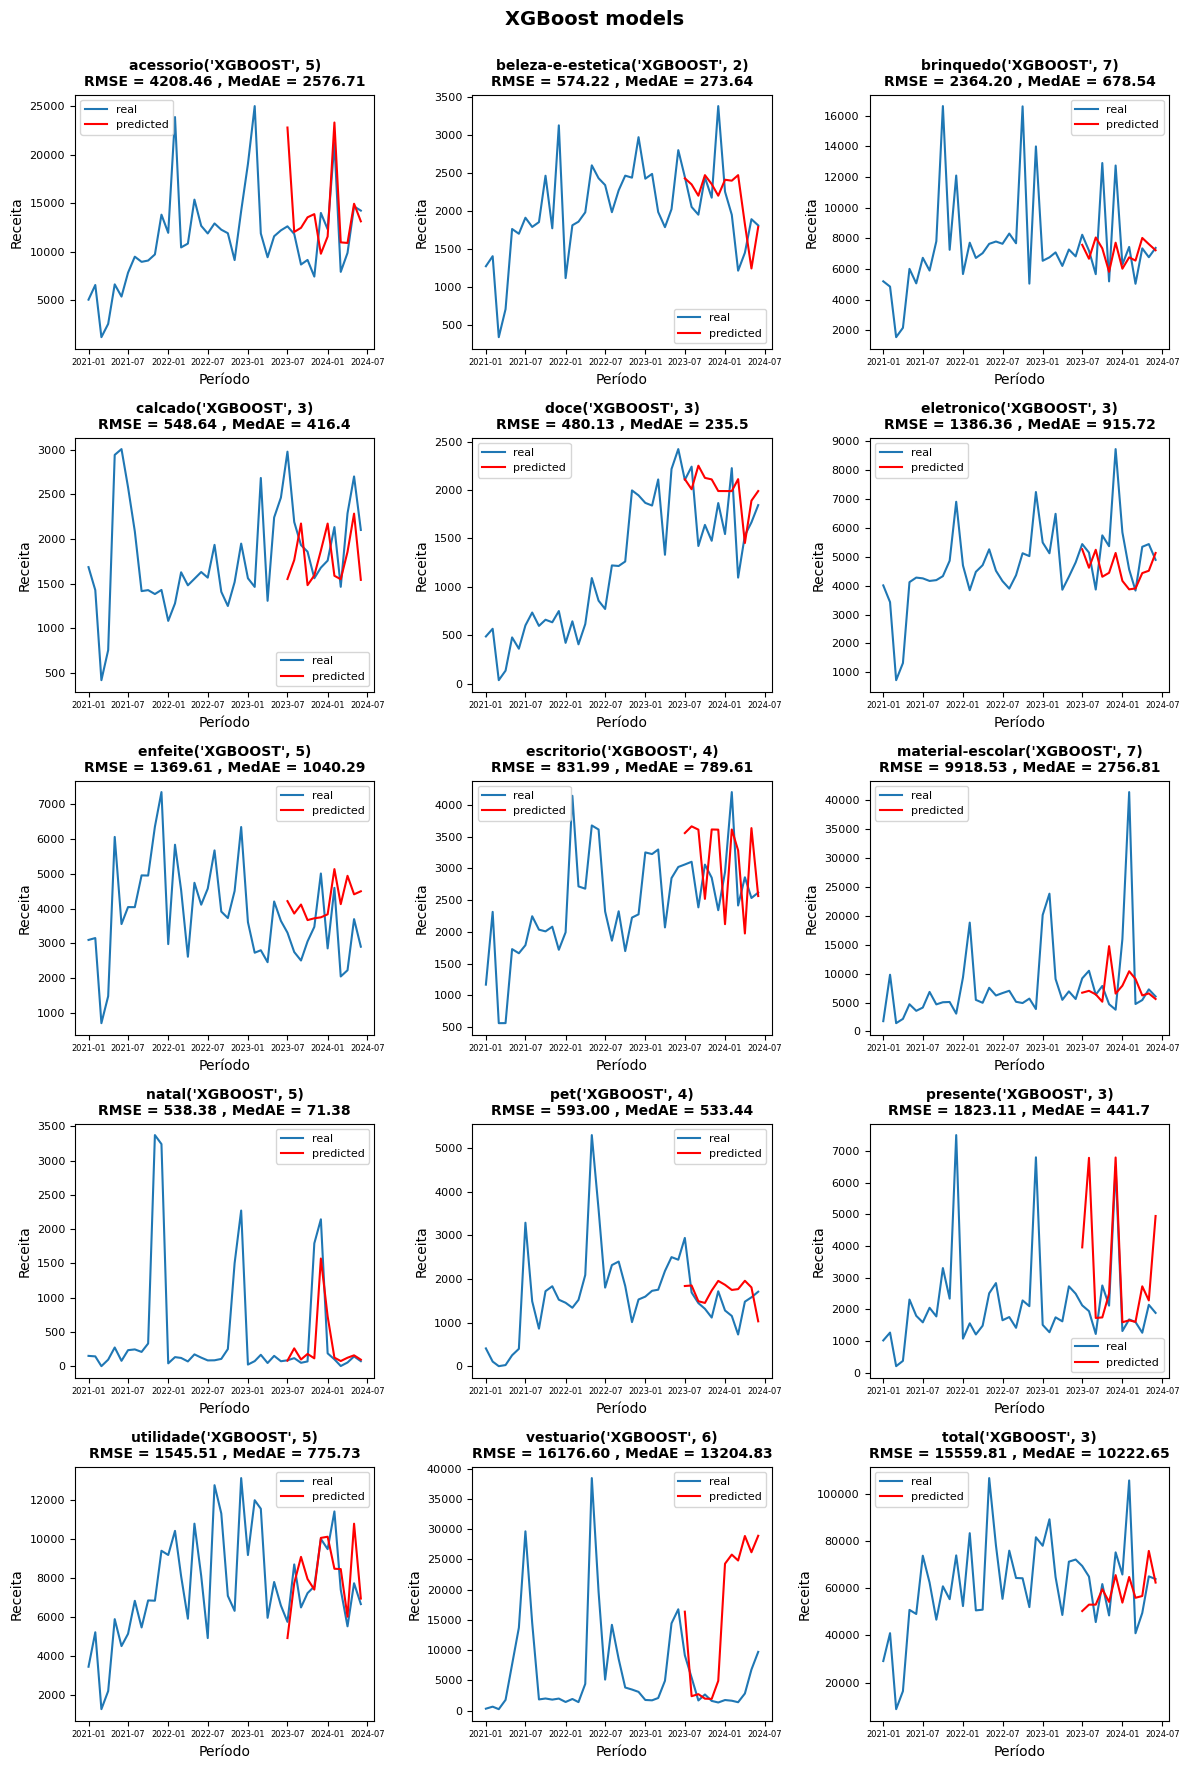

In [39]:
model_error_xgboost_1M = pd.DataFrame()

fig, ax = plt.subplots(5, 3, figsize=(12, 18))
ax = ax.flatten()
fig.suptitle('XGBoost models', weight='bold',fontsize=14)

for i, categoria in zip(range(len(ts.columns)), ts.columns):

  print(f'Processando {categoria}...')
  df = ts[[categoria]]
  pred = pred_1M_categoria[categoria]
  best_rmse_model = best_categoria_models[categoria]['best_rmse_model']

#-------------------------------------------------------------------------------

  #
  # get error metrics
  #
  metrics = {}

  metrics_df = pd.DataFrame.from_dict(error_metrics(df.iloc[-12::,0].values, pred), orient='index').transpose()
  metrics_df['ML Model'] = str(best_rmse_model[0])
  metrics_df['lag parameter'] = str(best_rmse_model[1])
  metrics_df = metrics_df.set_index(['ML Model','lag parameter'])

  select_metrics = ['RMSE', 'RMSE_std', 'MAPE',  'MAPE_std', 'MAPE_max', 'MAPE_min', 'MedAE' ]
  model_error_xgboost_1M = pd.concat([model_error_xgboost_1M,metrics_df[select_metrics]])

  #
  # plot results
  #

  y_true = df.iloc[:,0]   # série completa
  y_pred = pd.Series(data=pred, index=df.iloc[-12::,0].index)  # passa série com datas
  AICRMSE_str = 'RMSE'
  AICRMSE_value = metrics_df['RMSE'].values[0].round(2)
  MedAE = metrics_df['MedAE'].values[0].round(2)
  modelo = categoria + str(best_rmse_model)

  plot_results2(ax[i])

#-------------------------------------------------------------------------------
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

model_error_xgboost_1M.reset_index(inplace=True)
model_error_xgboost_1M['categoria'] = ts.columns





model_error_xgboost_1M.sort_values('MAPE')

In [40]:
temp = model_error_xgboost_1M.sort_values('MAPE')
temp.columns = [x.replace('_','-') for x in temp.columns]
latex_table = gera_df_stats_latex(temp,'XGBoost 1M, por categoria')

display(Latex(latex_table))

<IPython.core.display.Latex object>

### Meses com maior e menor erro de predição

Processando acessorio...
Processando beleza-e-estetica...
Processando brinquedo...
Processando calcado...
Processando doce...
Processando eletronico...
Processando enfeite...
Processando escritorio...
Processando material-escolar...
Processando natal...
Processando pet...
Processando presente...
Processando utilidade...
Processando vestuario...
Processando total...


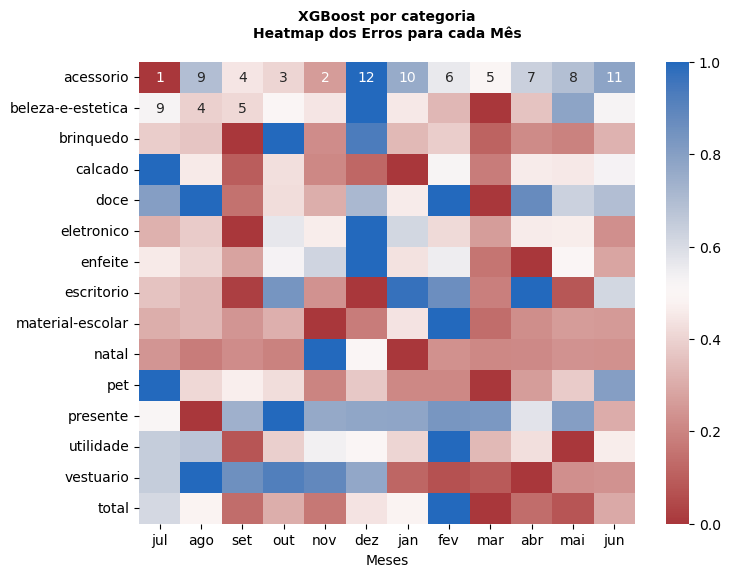

In [41]:
df_heatmap_all = pd.DataFrame()

for i, categoria in zip(range(len(ts.columns)), ts.columns):

  print(f'Processando {categoria}...')
  df = ts[[categoria]]
  pred = pred_1M_categoria[categoria]

  errors = df.iloc[-12::,0].values - pred

#-------------------------------------------------------------------------------
  labels = ['jul','ago','set','out','nov','dez','jan','fev','mar','abr','mai','jun']

  df_heatmap = pd.DataFrame({'labels': labels, 'errors': errors})

  df_heatmap = df_heatmap.pivot_table(index='labels', values='errors').transpose()
  df_heatmap = df_heatmap[['jul','ago','set','out','nov','dez','jan','fev','mar','abr','mai','jun']] # reorder

  df_heatmap_all = pd.concat([df_heatmap_all,df_heatmap])

#-------------------------------------------------------------------------------

df_heatmap_all.index = ts.columns
df_heatmap_all = df_heatmap_all.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1) # normaliza por categoria

plt.figure(figsize=(8,6))
sns.heatmap(df_heatmap_all, annot=df_heatmap_all.rank(axis="columns"), fmt=".0f", cmap=sns.color_palette("vlag_r", as_cmap=True))
plt.title(f'XGBoost por categoria\nHeatmap dos Erros para cada Mês\n',weight='bold',fontsize=10)
plt.xlabel('Meses')

plt.show()

# XGBoost: Predições 3M

In [42]:
pred_3M_categoria = {}

for i, categoria in zip(range(len(ts.columns)), ts.columns):

  df = ts[categoria]
  best_rmse_model = best_categoria_models[categoria]['best_rmse_model']
  print(f'Processando {categoria}... model {best_rmse_model}')
  n_lags = best_rmse_model[1]
  # n_lags = 3
  df = create_lagged_features(df, n_lags)

#-------------------------------------------------------------------------------

  models_stats = {}
  models_fittedvalues = {}

  X_train = df.iloc[0:-12,1:n_lags+1]
  y_train = df.iloc[0:-12,0]

  model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50)
  model_xgb.fit(X_train, y_train)

  forecast_steps = 3
  y_pred = np.zeros([9,forecast_steps])

  for i in range(9):
    rolling_predictions = forecast_rolling(model_xgb, df.iloc[i-12-n_lags:i-12,0].values, n_lags, forecast_steps)
    y_pred[i,:] = rolling_predictions

#-------------------------------------------------------------------------------

  pred_3M_categoria[categoria] = y_pred

Processando acessorio... model ('XGBOOST', 5)
Processando beleza-e-estetica... model ('XGBOOST', 2)
Processando brinquedo... model ('XGBOOST', 7)
Processando calcado... model ('XGBOOST', 3)
Processando doce... model ('XGBOOST', 3)
Processando eletronico... model ('XGBOOST', 3)
Processando enfeite... model ('XGBOOST', 5)
Processando escritorio... model ('XGBOOST', 4)
Processando material-escolar... model ('XGBOOST', 7)
Processando natal... model ('XGBOOST', 5)
Processando pet... model ('XGBOOST', 4)
Processando presente... model ('XGBOOST', 3)
Processando utilidade... model ('XGBOOST', 5)
Processando vestuario... model ('XGBOOST', 6)
Processando total... model ('XGBOOST', 3)


In [43]:
valores_window_3M_categoria = {}

for i, categoria in zip(range(len(ts.columns)), ts.columns):

  print(f'Processando {categoria}...')
  df = ts[[categoria]]

#-------------------------------------------------------------------------------
  valores_window = []
  for i in range(30, 39):
      valores_window.append(df.iloc[i:i+3].values)
#-------------------------------------------------------------------------------

  valores_window_3M_categoria[categoria] = valores_window

Processando acessorio...
Processando beleza-e-estetica...
Processando brinquedo...
Processando calcado...
Processando doce...
Processando eletronico...
Processando enfeite...
Processando escritorio...
Processando material-escolar...
Processando natal...
Processando pet...
Processando presente...
Processando utilidade...
Processando vestuario...
Processando total...


In [44]:
model_error_xgboost_3M = pd.DataFrame()

for i, categoria in zip(range(len(ts.columns)), ts.columns):

  best_rmse_model = best_categoria_models[categoria]['best_rmse_model']
  print(f'Processando {categoria}... model {best_rmse_model}')
  n_lags = best_rmse_model[1]
  pred = pred_3M_categoria[categoria]

#-------------------------------------------------------------------------------

  metrics_df = pd.DataFrame.from_dict(error_metrics(np.array(valores_window_3M_categoria[categoria]).flatten(), np.array(pred).flatten()), orient='index').transpose()
  metrics_df['ML Model'] = str(best_rmse_model[0])
  metrics_df['lag parameter'] = str(best_rmse_model[1])
  metrics_df = metrics_df.set_index(['ML Model','lag parameter'])

  select_metrics = ['RMSE', 'RMSE_std', 'MAPE',  'MAPE_std', 'MAPE_max', 'MAPE_min', 'MedAE' ]
  model_error = metrics_df[select_metrics]

  model_error_xgboost_3M = pd.concat([model_error_xgboost_3M,metrics_df[select_metrics]])

#-------------------------------------------------------------------------------

model_error_xgboost_3M.reset_index(inplace=True)
model_error_xgboost_3M['categoria'] = ts.columns

Processando acessorio... model ('XGBOOST', 5)
Processando beleza-e-estetica... model ('XGBOOST', 2)
Processando brinquedo... model ('XGBOOST', 7)
Processando calcado... model ('XGBOOST', 3)
Processando doce... model ('XGBOOST', 3)
Processando eletronico... model ('XGBOOST', 3)
Processando enfeite... model ('XGBOOST', 5)
Processando escritorio... model ('XGBOOST', 4)
Processando material-escolar... model ('XGBOOST', 7)
Processando natal... model ('XGBOOST', 5)
Processando pet... model ('XGBOOST', 4)
Processando presente... model ('XGBOOST', 3)
Processando utilidade... model ('XGBOOST', 5)
Processando vestuario... model ('XGBOOST', 6)
Processando total... model ('XGBOOST', 3)


In [45]:
model_error_xgboost_3M.sort_values('MAPE')

,ML Model,lag parameter,RMSE,RMSE_std,MAPE,MAPE_std,MAPE_max,MAPE_min,MedAE,categoria
3,XGBOOST,3,534.88,356.96,0.19,0.14,0.52,0.01,283.01,calcado
14,XGBOOST,3,16900.37,11254.48,0.19,0.14,0.63,0.02,9806.70,total
12,XGBOOST,5,2021.56,1191.81,0.22,0.20,0.62,0.03,1260.80,utilidade
1,XGBOOST,2,584.76,366.31,0.25,0.27,1.00,0.01,374.81,beleza-e-estetica
2,XGBOOST,7,3117.78,2135.95,0.26,0.16,0.49,0.02,1509.62,brinquedo
5,XGBOOST,3,1860.56,1140.13,0.26,0.14,0.51,0.02,1239.11,eletronico
7,XGBOOST,4,836.67,383.21,0.28,0.18,0.55,0.06,591.58,escritorio
4,XGBOOST,3,582.24,316.73,0.34,0.27,0.93,0.00,487.44,doce
0,XGBOOST,5,5793.29,3053.72,0.44,0.26,0.90,0.05,4355.00,acessorio
6,XGBOOST,5,1463.49,889.90,0.44,0.43,1.53,0.03,856.19,enfeite


In [46]:
temp = model_error_xgboost_3M.sort_values('MAPE')
temp.columns = [x.replace('_','-') for x in temp.columns]
latex_table = gera_df_stats_latex(temp,'XGBoost 3M, por categoria')

display(Latex(latex_table))

<IPython.core.display.Latex object>

# Comparando resultado dos modelos

In [47]:
xgboost_1M = model_error_xgboost_1M.sort_values('MAPE')
xgboost_1M.columns = [x.replace('_','-') for x in xgboost_1M.columns]
xgboost_1M['modelo'] = xgboost_1M['ML Model'] + '_' + xgboost_1M['lag parameter'].astype(str)
selected_columns = ['categoria', 'modelo', 'RMSE', 'RMSE-std', 'MAPE', 'MAPE-std', 'MedAE']
xgboost_1M = xgboost_1M[selected_columns]

arima_1M = model_error_arima_1M.sort_values('MAPE')
arima_1M.columns = [x.replace('_','-') for x in arima_1M.columns]
arima_1M['modelo'] = 'SARIMA_' + arima_1M['order'] + '_' + arima_1M['seasonal order'].astype(str)
selected_columns = ['categoria', 'modelo', 'RMSE', 'RMSE-std', 'MAPE', 'MAPE-std', 'MedAE']
arima_1M = arima_1M[selected_columns]

results = pd.concat([xgboost_1M,arima_1M]).reset_index(drop=True)
results.sort_values(['categoria','RMSE'])

results_min_rmse_1M = results.loc[results.groupby('categoria')['RMSE'].idxmin()].sort_values('MAPE').reset_index(drop=True)
display(results_min_rmse_1M)

,categoria,modelo,RMSE,RMSE-std,MAPE,MAPE-std,MedAE
0,calcado,"SARIMA_(1, 1, 1)_(0, 0, 0, 12)",448.15,306.49,0.15,0.12,270.61
1,utilidade,"SARIMA_(2, 1, 0)_(1, 0, 0, 12)",1391.19,784.65,0.16,0.11,1280.15
2,acessorio,"SARIMA_(0, 1, 1)_(1, 0, 0, 12)",2378.67,1075.09,0.18,0.10,2398.96
3,eletronico,XGBOOST_3,1386.36,910.90,0.18,0.12,915.72
4,escritorio,"SARIMA_(0, 1, 1)_(1, 0, 0, 12)",591.31,302.45,0.18,0.10,495.46
5,total,XGBOOST_3,15559.81,9974.64,0.18,0.11,10222.65
6,brinquedo,"SARIMA_(0, 1, 2)_(1, 0, 0, 12)",1555.58,678.02,0.20,0.13,1508.05
7,beleza-e-estetica,"SARIMA_(0, 1, 1)_(1, 0, 0, 12)",472.97,279.33,0.21,0.20,279.62
8,doce,"SARIMA_(0, 1, 1)_(0, 0, 0, 12)",415.00,274.28,0.21,0.23,198.15
9,enfeite,"SARIMA_(0, 1, 1)_(1, 0, 0, 12)",875.52,539.97,0.22,0.18,367.41


In [48]:
latex_table = gera_df_stats_latex(results_min_rmse_1M,'Melhores modelos, 1M')
display(Latex(latex_table))

<IPython.core.display.Latex object>

In [49]:
xgboost_3M = model_error_xgboost_3M.sort_values('MAPE')
xgboost_3M.columns = [x.replace('_','-') for x in xgboost_3M.columns]
xgboost_3M['modelo'] = xgboost_3M['ML Model'] + '_' + xgboost_3M['lag parameter'].astype(str)
selected_columns = ['categoria', 'modelo', 'RMSE', 'RMSE-std', 'MAPE', 'MAPE-std', 'MedAE']
xgboost_3M = xgboost_3M[selected_columns]

arima_3M = model_error_arima_3M.sort_values('MAPE')
arima_3M.columns = [x.replace('_','-') for x in arima_3M.columns]
arima_3M['modelo'] = 'SARIMA_' + arima_3M['order'] + '_' + arima_3M['seasonal order'].astype(str)
selected_columns = ['categoria', 'modelo', 'RMSE', 'RMSE-std', 'MAPE', 'MAPE-std', 'MedAE']
arima_3M = arima_3M[selected_columns]

results = pd.concat([xgboost_3M,arima_3M]).reset_index(drop=True)
results.sort_values(['categoria','RMSE'])

results_min_rmse_3M = results.loc[results.groupby('categoria')['RMSE'].idxmin()].sort_values('MAPE').reset_index(drop=True)
display(results_min_rmse_1M)

,categoria,modelo,RMSE,RMSE-std,MAPE,MAPE-std,MedAE
0,calcado,"SARIMA_(1, 1, 1)_(0, 0, 0, 12)",448.15,306.49,0.15,0.12,270.61
1,utilidade,"SARIMA_(2, 1, 0)_(1, 0, 0, 12)",1391.19,784.65,0.16,0.11,1280.15
2,acessorio,"SARIMA_(0, 1, 1)_(1, 0, 0, 12)",2378.67,1075.09,0.18,0.10,2398.96
3,eletronico,XGBOOST_3,1386.36,910.90,0.18,0.12,915.72
4,escritorio,"SARIMA_(0, 1, 1)_(1, 0, 0, 12)",591.31,302.45,0.18,0.10,495.46
5,total,XGBOOST_3,15559.81,9974.64,0.18,0.11,10222.65
6,brinquedo,"SARIMA_(0, 1, 2)_(1, 0, 0, 12)",1555.58,678.02,0.20,0.13,1508.05
7,beleza-e-estetica,"SARIMA_(0, 1, 1)_(1, 0, 0, 12)",472.97,279.33,0.21,0.20,279.62
8,doce,"SARIMA_(0, 1, 1)_(0, 0, 0, 12)",415.00,274.28,0.21,0.23,198.15
9,enfeite,"SARIMA_(0, 1, 1)_(1, 0, 0, 12)",875.52,539.97,0.22,0.18,367.41


In [50]:
latex_table = gera_df_stats_latex(results_min_rmse_3M,'Melhores modelos, 3M')
display(Latex(latex_table))

<IPython.core.display.Latex object>

In [51]:
results = pd.merge(results_min_rmse_1M[['categoria','modelo','MAPE']],results_min_rmse_3M[['categoria','modelo','MAPE']],on='categoria')
results.columns = ['categoria','modelo_1M','MAPE-1M','modelo-3M','MAPE-3M']
results

,categoria,modelo_1M,MAPE-1M,modelo-3M,MAPE-3M
0,calcado,"SARIMA_(1, 1, 1)_(0, 0, 0, 12)",0.15,XGBOOST_3,0.19
1,utilidade,"SARIMA_(2, 1, 0)_(1, 0, 0, 12)",0.16,XGBOOST_5,0.22
2,acessorio,"SARIMA_(0, 1, 1)_(1, 0, 0, 12)",0.18,XGBOOST_5,0.44
3,eletronico,XGBOOST_3,0.18,XGBOOST_3,0.26
4,escritorio,"SARIMA_(0, 1, 1)_(1, 0, 0, 12)",0.18,XGBOOST_4,0.28
5,total,XGBOOST_3,0.18,XGBOOST_3,0.19
6,brinquedo,"SARIMA_(0, 1, 2)_(1, 0, 0, 12)",0.20,XGBOOST_7,0.26
7,beleza-e-estetica,"SARIMA_(0, 1, 1)_(1, 0, 0, 12)",0.21,XGBOOST_2,0.25
8,doce,"SARIMA_(0, 1, 1)_(0, 0, 0, 12)",0.21,XGBOOST_3,0.34
9,enfeite,"SARIMA_(0, 1, 1)_(1, 0, 0, 12)",0.22,XGBOOST_5,0.44


In [52]:
latex_table = gera_df_stats_latex(results,'Melhores modelos, 3M')
display(Latex(latex_table))

<IPython.core.display.Latex object>